In [1]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()

print(bucket)

sagemaker-us-east-1-011113936377


In [2]:
!aws s3 sync s3://{bucket}/wsb/data/ data/

In [3]:
import sys
import re
import os
import json
import datetime
import pytz
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
token_pattern = re.compile(r"(?u)\b\w\w+\b")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc.lower()) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t) and t.upper() not in allsymbols]


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
ET = pytz.timezone('US/Eastern')

ignorelist=["DD","FREE","CASH","ON","I"]
allsymbols=[]
with open("allsymbols.txt") as fh:
  allsymbols=fh.readlines()
allsymbols = [x.strip() for x in allsymbols]

dt=datetime.timedelta(days=7)

wnl = WordNetLemmatizer()


In [6]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [7]:
import datetime

stockdata={}
def getstockprice(symbol,date):
    if symbol not in stockdata:
        with open("stockprices/"+symbol,"r") as fh:
            data=json.load(fh)
        stockdata[symbol]={}
        for stockday in data:
            indate=datetime.datetime.strptime(stockday["begins_at"],"%Y-%m-%dT%H:%M:%SZ").date()
            stockdata[symbol][indate]=stockday
    today=datetime.date.today()
    while True:
        #print(date)
        if date in stockdata[symbol]:
            return float(stockdata[symbol][date]['close_price'])
        date=date+datetime.timedelta(days=1)
        if date>today:
            break
    raise Exception("No stock data found")
    return None
            

In [8]:
files = os.listdir("data/")

foundsymbols=[]
relevant_posts = []
i=0
for file in files:
  if(round(i/100,0)==i/100):
        update_progress(i / len(files))  
  with open("data/"+file,"r") as fh:
    try:
        data=json.load(fh)
        text = (data["title"]+" "+data["selftext"]).replace('\"','').replace('\'','')
        allmatches=[]
        matches=re.findall('\W*([A-Z][A-Z\.]{0,3})\W',text)
        for submatch in matches:
            allmatches.append({submatch:submatch})
            #pass
        matches2=re.findall('\W*(\$[a-z\.]{1,4})',text)
        for submatch in matches2:
            allmatches.append({submatch.upper()[1:]:submatch})
        thesesymbols=[]
        #print(allmatches)
        for submatch in allmatches:
            symbol=list(submatch.keys())[0]
            #print(submatch.keys())
            #print(symbol)
            #print([list(x.keys())[0] for x in thesesymbols])
            if symbol in allsymbols and symbol not in [list(x.keys())[0] for x in thesesymbols] and symbol not in ignorelist:
                thesesymbols.append(submatch)
                if symbol not in foundsymbols:
                    foundsymbols.append(symbol)
        if len(thesesymbols)>0:
            relevant_posts.append({"data":data,"symbols":thesesymbols})
            #print(thesesymbols)
    except Exception as err:
      print("Error with",file)
      raise(err)
  i+=1
    

  #if i>1000:
  #  break



Progress: [####################] 99.9%


In [9]:
print(len(foundsymbols))
with open("foundsymbols.txt","w") as fh:
  fh.write("\n".join(foundsymbols))
foundsymbols

3661


['TSLA',
 'B',
 'AMZN',
 'COST',
 'C',
 'LULU',
 'AMD',
 'FB',
 'PTON',
 'AAPL',
 'GOLD',
 'ROKU',
 'NFLX',
 'DIS',
 'HAS',
 'GOOD',
 'ONCY',
 'SPCE',
 'AMC',
 'KR',
 'PM',
 'ABC',
 'X',
 'Y',
 'CYBR',
 'PANW',
 'RPD',
 'EDIT',
 'DTE',
 'DCOM',
 'AT',
 'ACB',
 'THC',
 'MU',
 'IP',
 'AG',
 'GILD',
 'TJX',
 'HTZ',
 'TVTY',
 'DGX',
 'QQQ',
 'TA',
 'BYND',
 'POST',
 'SR',
 'NIO',
 'RING',
 'A',
 'NEW',
 'IT',
 'FOSL',
 'BK',
 'PINS',
 'KRTX',
 'OVID',
 'DOW',
 'SBUX',
 'VC',
 'MCD',
 'MSFT',
 'WMT',
 'SNAP',
 'PECK',
 'HUGE',
 'GDP',
 'WELL',
 'CDC',
 'BA',
 'V',
 'FAT',
 'NOC',
 'LMT',
 'RH',
 'AAL',
 'GO',
 'SDC',
 'ALGN',
 'ONE',
 'ATVI',
 'M',
 'CEO',
 'K',
 'ALLY',
 'SIX',
 'CME',
 'AM',
 'LIVE',
 'FIT',
 'SWBI',
 'EC',
 'F',
 'CRM',
 'BAC',
 'CTO',
 'PEP',
 'UAL',
 'DAL',
 'JNJ',
 'PCG',
 'E',
 'PLUS',
 'AMTD',
 'TTD',
 'DEA',
 'CBD',
 'CCL',
 'ARE',
 'OUT',
 'G',
 'BMO',
 'IONS',
 'FOR',
 'HAL',
 'INFY',
 'KO',
 'SYF',
 'NDAQ',
 'NEE',
 'ERIC',
 'DPZ',
 'LUV',
 'UNP',
 'AXP',
 'SNY'

In [10]:
#split into multiple corpus here


import random
random.shuffle(relevant_posts)
n_train = int(0.8 * len(relevant_posts))

training_posts = relevant_posts[:n_train]
test_posts = relevant_posts[n_train:]
val_posts = test_posts[:n_train//2]
test_posts = test_posts[n_train//2:]

vocab_input = [t["data"]["title"]+" "+t["data"]["selftext"] for t in training_posts]
print(len(relevant_posts),n_train)

34504 27603


In [11]:
test_posts = relevant_posts[n_train:]
print(n_train,n_train//2)
test_posts = relevant_posts[n_train:]
print(len(test_posts))
print(len(test_posts)//2)
val_posts = test_posts[:len(test_posts)//2]
test_posts = test_posts[len(test_posts)//2:]
len(test_posts)

27603 13801
6901
3450


3451

In [12]:
vocab_size=5000

vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english', tokenizer=LemmaTokenizer(), max_features=vocab_size, max_df=0.95, min_df=2)

vectors = vectorizer.fit_transform(vocab_input)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


vocab size: 5000


In [13]:
vocab_list

['abbott',
 'abbvie',
 'ability',
 'able',
 'aboard',
 'absolute',
 'absolutely',
 'absurd',
 'abuse',
 'accelerate',
 'accelerated',
 'accelerating',
 'acceleration',
 'accept',
 'accepted',
 'accepting',
 'access',
 'accessory',
 'accident',
 'accidentally',
 'according',
 'accordingly',
 'account',
 'accountant',
 'accounted',
 'accounting',
 'accurate',
 'achieve',
 'achieved',
 'ackman',
 'acquire',
 'acquired',
 'acquires',
 'acquiring',
 'acquisition',
 'act',
 'acted',
 'acting',
 'action',
 'active',
 'actively',
 'activision',
 'activist',
 'activity',
 'actual',
 'actually',
 'ad',
 'adam',
 'adapt',
 'add',
 'added',
 'adderall',
 'addict',
 'addicted',
 'addiction',
 'adding',
 'addition',
 'additional',
 'additionally',
 'address',
 'adj',
 'adjust',
 'adjusted',
 'adjustment',
 'administration',
 'admit',
 'adoption',
 'adult',
 'advance',
 'advanced',
 'advantage',
 'adverse',
 'advertisement',
 'advertiser',
 'advertising',
 'advice',
 'advise',
 'advised',
 'adviser',

In [14]:
threshhold=.1
lt = LemmaTokenizer()
from scipy.sparse import csr_matrix

def calculateData(post):
    #print(post)
    data=post["data"]
    thesesymbols=post["symbols"]
    text = data["title"]+" "+data["selftext"]
    texttokens=lt(text)
    #print(text,texttokens)
    #print("Symbol:",thesesymbols)
    wordvector=[]
    for word in vocab_list:
        wordvector.append(texttokens.count(word))
    returnarray=[]
    for symbolmap in thesesymbols:
        symbol=list(symbolmap.keys())[0]
        try:
        #if True:
            
                #if word in texttokens:
                    #print(word)
                #    wordvector.append(1)
                #else:
                #    wordvector.append(0)
                #locword = text.find(word)
                #distance=0
                #if locword>-1:
                #    distance=abs(text.find(symbolmap[symbol])-locword)
                #    print(symbol,word,distance)
                #wordvector.append(distance)
            #print(symbol,wordvector)
            start=ET.localize(datetime.datetime.fromtimestamp(data["created_utc"]))
            if start.hour>=9:
              start=start+datetime.timedelta(days=1)
            start=start.replace(hour=9,minute=0,second=0,microsecond=0).date()
            end=start+dt
            startprice=getstockprice(symbol,start)
            endprice=getstockprice(symbol,end)
            #print(start,end,history)
            delta=(endprice-startprice)/startprice
            if delta<=-1*(threshhold):
                result=1
            elif delta>=threshhold:
                result=2
                #print(symbol,delta,result,wordvector)
            else:
                result=0
            returnarray.append([result]+wordvector)
        except Exception as err:
            print("Error with",symbol,", skipping this one:",err)
    return returnarray



training_vector = []
i=0
for posts in training_posts:
    #try:
    if True:
       response=calculateData(posts)
       for row in response:
            training_vector.append(row)
    #except Exception as err:
    #    print("Error",err)
    #    pass
    i+=1
    if(round(i/100,0)==i/100):
        update_progress(i / len(training_posts))
        print(len(training_posts))



Progress: [####################] 100.0%
27603


In [15]:
import pandas as pd
pd.DataFrame(training_vector, columns=["Output"]+vocab_list)

,Output,abbott,abbvie,ability,able,aboard,absolute,absolutely,absurd,abuse,...,yr/yr,ytd,yuan,zealand,zero,zillow,zombie,zone,zoom,zynga
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68032,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68033,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68034,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
import boto3
import sagemaker.amazon.common as smac
import io

np_training_vector = np.array(training_vector).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np_training_vector[:,1:], np_training_vector[:,0])
buf.seek(0)

prefix = 'wsb-training'
key= 'wsb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))


output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))





uploaded training data location: s3://sagemaker-us-east-1-011113936377/wsb-training/train/wsb-data
training artifacts will be uploaded to: s3://sagemaker-us-east-1-011113936377/wsb-training/output


In [17]:


from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

from sagemaker import get_execution_role

role = get_execution_role()
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=session)
linear.set_hyperparameters(feature_dim=len(vocab_list),
                           predictor_type='multiclass_classifier',
                           num_classes=3,
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-07-16 20:02:35 Starting - Starting the training job...
2020-07-16 20:02:38 Starting - Launching requested ML instances......
2020-07-16 20:04:01 Starting - Preparing the instances for training......
2020-07-16 20:04:53 Downloading - Downloading input data......
2020-07-16 20:06:04 Training - Downloading the training image...
2020-07-16 20:06:26 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/16/2020 20:06:35 INFO 139714397374272] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5

[2020-07-16 20:08:16.247] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 53089, "num_examples": 341, "num_bytes": 1364277924}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 3.2341538115108714, "sum": 3.2341538115108714, "min": 3.2341538115108714}}, "EndTime": 1594930096.24794, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1594930096.247852}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 6.555051060620476, "sum": 6.555051060620476, "min": 6.555051060620476}}, "EndTime": 1594930096.248025, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1594930096.248004}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 8.988023205925437, "sum": 8.988023205925437, "min": 8.9880232

[2020-07-16 20:09:11.986] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 55724, "num_examples": 341, "num_bytes": 1364277924}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.5577835943558638, "sum": 2.5577835943558638, "min": 2.5577835943558638}}, "EndTime": 1594930151.986251, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1594930151.986158}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.9618104420830225, "sum": 5.9618104420830225, "min": 5.9618104420830225}}, "EndTime": 1594930151.986326, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1594930151.986309}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 8.727599731445313, "sum": 8.727599731445313, "min": 8.727

[2020-07-16 20:10:10.106] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 58108, "num_examples": 341, "num_bytes": 1364277924}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 2.0419076802309823, "sum": 2.0419076802309823, "min": 2.0419076802309823}}, "EndTime": 1594930210.106835, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1594930210.106592}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 6.234971456976498, "sum": 6.234971456976498, "min": 6.234971456976498}}, "EndTime": 1594930210.106935, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1594930210.106915}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 6.779320844538072, "sum": 6.779320844538072, "min": 6.779320

[2020-07-16 20:11:27.421] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 77301, "num_examples": 341, "num_bytes": 1364277924}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 1.7481646785736085, "sum": 1.7481646785736085, "min": 1.7481646785736085}}, "EndTime": 1594930287.421236, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1594930287.42113}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 6.451567760018741, "sum": 6.451567760018741, "min": 6.451567760018741}}, "EndTime": 1594930287.421335, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1594930287.421315}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.518754532309139, "sum": 5.518754532309139, "min": 5.518754

[2020-07-16 20:12:52.290] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 84856, "num_examples": 341, "num_bytes": 1364277924}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 1.558741639586056, "sum": 1.558741639586056, "min": 1.558741639586056}}, "EndTime": 1594930372.290789, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1594930372.290551}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 6.407262610940372, "sum": 6.407262610940372, "min": 6.407262610940372}}, "EndTime": 1594930372.290887, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1594930372.290871}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.518754532309139, "sum": 5.518754532309139, "min": 5.51875453

[2020-07-16 20:14:18.429] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 86127, "num_examples": 341, "num_bytes": 1364277924}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 1.4938133549970738, "sum": 1.4938133549970738, "min": 1.4938133549970738}}, "EndTime": 1594930458.430233, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1594930458.42999}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.833096954121309, "sum": 5.833096954121309, "min": 5.833096954121309}}, "EndTime": 1594930458.430316, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1594930458.430296}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.518754532309139, "sum": 5.518754532309139, "min": 5.518754

[2020-07-16 20:15:43.705] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 17, "duration": 85261, "num_examples": 341, "num_bytes": 1364277924}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 1.4654995673684512, "sum": 1.4654995673684512, "min": 1.4654995673684512}}, "EndTime": 1594930543.705242, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1594930543.705147}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.8940424104578355, "sum": 5.8940424104578355, "min": 5.8940424104578355}}, "EndTime": 1594930543.705344, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1594930543.705323}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.518754532309139, "sum": 5.518754532309139, "min": 5.51

[2020-07-16 20:17:08.851] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 85134, "num_examples": 341, "num_bytes": 1364277924}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 1.4454256199107451, "sum": 1.4454256199107451, "min": 1.4454256199107451}}, "EndTime": 1594930628.851624, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1594930628.85153}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.729132558934829, "sum": 5.729132558934829, "min": 5.729132558934829}}, "EndTime": 1594930628.851708, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1594930628.851693}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.518754532309139, "sum": 5.518754532309139, "min": 5.518754

[2020-07-16 20:18:33.728] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 21, "duration": 84866, "num_examples": 341, "num_bytes": 1364277924}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 1.4355038792666266, "sum": 1.4355038792666266, "min": 1.4355038792666266}}, "EndTime": 1594930713.729091, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1594930713.728998}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.757246487337, "sum": 5.757246487337, "min": 5.757246487337}}, "EndTime": 1594930713.729174, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1594930713.72916}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.518754532309139, "sum": 5.518754532309139, "min": 5.518754532309139

[2020-07-16 20:19:57.744] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 84004, "num_examples": 341, "num_bytes": 1364277924}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 1.430477965074427, "sum": 1.430477965074427, "min": 1.430477965074427}}, "EndTime": 1594930797.74501, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1594930797.744896}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.834825040705064, "sum": 5.834825040705064, "min": 5.834825040705064}}, "EndTime": 1594930797.745104, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1594930797.745088}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 5.518754532309139, "sum": 5.518754532309139, "min": 5.5187545


2020-07-16 20:20:11 Uploading - Uploading generated training model
2020-07-16 20:20:11 Completed - Training job completed
Training seconds: 918
Billable seconds: 918


In [18]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

-----------------!

In [19]:
test_vector = []
i=0
for posts in test_posts:
    #try:
    if True:
       response=calculateData(posts)
       for row in response:
            test_vector.append(row)
    #except Exception as err:
    #    print("Error",err)
    #    pass
    i+=1
    if True:
        update_progress(i / len(test_posts))
        print(len(test_posts))
np_test_vector = np.array(test_vector).astype('float32')

Progress: [####################] 100.0%
3451


In [20]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [21]:
np_test_vector[:4,1:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
result = linear_predictor.predict(np_training_vector[:4,1:])
print(result)

{'predictions': [{'score': [0.7422065734863281, 0.15997351706027985, 0.09781988710165024], 'predicted_label': 0}, {'score': [0.749974250793457, 0.15674208104610443, 0.09328370541334152], 'predicted_label': 0}, {'score': [0.8263537287712097, 0.10001899302005768, 0.0736272782087326], 'predicted_label': 0}, {'score': [0.6814513802528381, 0.21714790165424347, 0.10140072554349899], 'predicted_label': 0}]}


In [23]:
import numpy as np

predictions = []
for array in np.array_split(np_test_vector[:,1:], 100):
    #print(array)
    result = linear_predictor.predict(array)
    #print(result)
    predictions += [r['predicted_label'] for r in result['predictions']]
#print(predictions)
predictions = np.array(predictions)


In [24]:
test_labels=[]
for value in np_test_vector[:,0]:
    #print(value[0])
    test_labels.append(value)
print(len(test_labels),len(predictions))

9830 9830


In [25]:
import pandas as pd

pd.crosstab([test_labels], predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0,1,2
actuals,,,
0.0,7397,35,16
1.0,1364,25,3
2.0,977,11,2


In [26]:
import numpy
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([10, 10], numpy.int32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[int(predicted), int(actual)] += 1
    
    return error, confusions

Test error: 24.5%


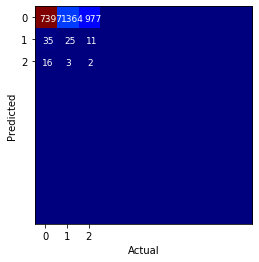

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline  

NUM_LABELS = 3  # change it according to num_class in your dataset
test_error, confusions = error_rate(numpy.asarray(predictions), numpy.asarray(test_labels))
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

In [28]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)